In [17]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import keras_tuner 
import tensorflow as tf
import tensorflow.keras
from keras.utils.np_utils import to_categorical
#from keras.preprocessing.image import ImageDataGenerator

In [3]:
path = 'Desktop\\myData'
myList = os.listdir(path)
TestRatio = 0.2
ValRatio = 0.2
threshold = 0.6
NumClasses = len(myList)

In [4]:
#read in data
images = []
ClassVals =[]
for x in range(0,NumClasses):
    #open each folder
    NumList = os.listdir(path+'/'+str(x))
    #list for x
    for y in NumList:
        curImg = cv2.imread(path+'/'+str(x)+'/'+y)
        curImg = cv2.resize(curImg,(32,32))
        images.append(curImg)
        #list for y
        ClassVals.append(x)
    print(x)   

0
1
2
3
4
5
6
7
8
9


In [12]:
#preprocessing images
def preProcessing(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img/255
    return img

In [21]:
def prepareData(images, ClassVals):
    images = np.array(images)
    ClassVals = np.array(ClassVals)
    #splitting data
    X_train, X_test, y_train, y_test = train_test_split(images, ClassVals, test_size = TestRatio)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = ValRatio)
    #formatting image
    X_train = np.array(list(map(preProcessing, X_train)))
    X_test = np.array(list(map(preProcessing, X_test)))
    X_validation = np.array(list(map(preProcessing, X_validation)))
    #adding extra dim
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
    
    dataGen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, shear_range=0.1, rotation_range=10)
    
    dataGen.fit(X_train)

    y_train = to_categorical(y_train, NumClasses)
    y_test = to_categorical(y_test, NumClasses)
    y_validation = to_categorical(y_validation, NumClasses)

    return X_train, X_test, X_validation, y_train, y_test, y_validation

In [22]:
X_train, X_test, X_validation, y_train, y_test, y_validation = prepareData(images, ClassVals)

In [23]:
print("size train set:", X_train.shape)
print("size test set:", X_test.shape)
print("size validation set:", X_validation.shape)

size train set: (6502, 32, 32, 1)
size test set: (2032, 32, 32, 1)
size validation set: (1626, 32, 32, 1)


In [9]:
#histogram of nr. of images per digit
len_classes =[]
for x in range(0,NumClasses):
    len_classes.append(len(np.where(y_train==x)[0]))

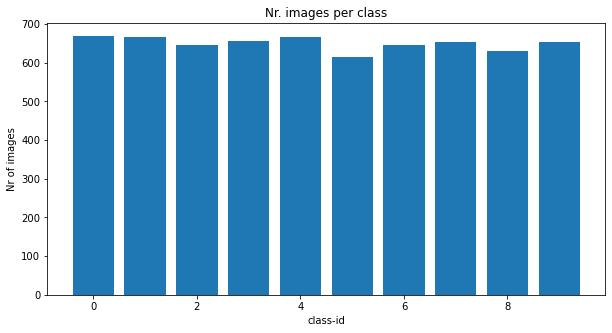

In [11]:
plt.figure(figsize=(10,5))
plt.bar(range(0, NumClasses), len_classes)
plt.title("Nr. images per class")
plt.xlabel("class-id")
plt.ylabel("Nr of images")
plt.show()

In [19]:
def myModel(hp):
    
    sizeOfFilter1 = (5,5)
    sizeOfFilter2 = (3,3)
    sizeOfPool = (2,2)
    noOfNodes = 500
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=hp.Int('Conv1_filter', min_value=32, max_value=128, step=16), kernel_size=sizeOfFilter1, input_shape=(32,32,1), activation='relu'))
    model.add(tf.keras.layers.Conv2D(filters=hp.Int('Conv2_filter', min_value=32, max_value=128, step=16), kernel_size=sizeOfFilter1, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=sizeOfPool))
    model.add(tf.keras.layers.Conv2D(filters=hp.Int('Conv3_filter', min_value=32, max_value=128, step=16), kernel_size=sizeOfFilter2, activation='relu'))
    model.add(tf.keras.layers.Conv2D(filters=hp.Int('Conv4_filter', min_value=32, max_value=128, step=16), kernel_size=sizeOfFilter2, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=sizeOfPool))
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(noOfNodes, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(NumClasses, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return(model)

In [20]:
#keras-tuner
tuner = keras_tuner.RandomSearch(
    myModel,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=5,
    directory='output',
    project_name="Digit-Recognizer")

INFO:tensorflow:Reloading Oracle from existing project output\Digit-Recognizer\oracle.json
INFO:tensorflow:Reloading Tuner from output\Digit-Recognizer\tuner0.json


In [28]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
Conv1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
Conv2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
Conv3_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
Conv4_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}


In [29]:
tuner.search(X_train, y_train, epochs=5, validation_data=(X_validation, y_validation))

Trial 5 Complete [00h 06m 45s]
val_accuracy: 0.9931119322776795

Best val_accuracy So Far: 0.9943419337272644
Total elapsed time: 00h 39m 19s
INFO:tensorflow:Oracle triggered exit


In [38]:
tuner.results_summary()

Results summary
Results in output\Digit-Recognizer
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
Conv1_filter: 48
Conv2_filter: 96
Conv3_filter: 96
Conv4_filter: 96
Score: 0.9943419337272644
Trial summary
Hyperparameters:
Conv1_filter: 96
Conv2_filter: 64
Conv3_filter: 112
Conv4_filter: 112
Score: 0.9933579325675964
Trial summary
Hyperparameters:
Conv1_filter: 32
Conv2_filter: 96
Conv3_filter: 112
Conv4_filter: 112
Score: 0.9932349324226379
Trial summary
Hyperparameters:
Conv1_filter: 48
Conv2_filter: 96
Conv3_filter: 96
Conv4_filter: 64
Score: 0.9931119322776795
Trial summary
Hyperparameters:
Conv1_filter: 96
Conv2_filter: 112
Conv3_filter: 128
Conv4_filter: 48
Score: 0.9928659319877624


In [54]:
#model with tuned hyperparameter
def OptModel():
    sizeOfFilter1 = (5,5)
    sizeOfFilter2 = (3,3)
    sizeOfPool = (2,2)
    noOfNodes = 500

    model = tf.keras.Sequential()
    model.add((tf.keras.layers.Conv2D(48, sizeOfFilter1, input_shape=(32,32,1), activation='relu')))
    model.add((tf.keras.layers.Conv2D(96, sizeOfFilter1, activation='relu')))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=sizeOfPool))
    model.add((tf.keras.layers.Conv2D(96, sizeOfFilter2, activation='relu')))
    model.add((tf.keras.layers.Conv2D(96, sizeOfFilter2, activation='relu')))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=sizeOfPool))
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(noOfNodes, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(NumClasses, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return(model)

In [56]:
model = OptModel()
batchSize = 50
epochsVal = 20
stepsPerEpochs = 2000

history = model.fit(dataGen.flow(X_train, y_train, batch_size = batchSize), steps_per_epoch = len(X_train)/batchSize,
                                 epochs = epochsVal, validation_data = (X_validation, y_validation), 
                                 shuffle =1)

# steps_per_epoch = stepsPerEpochs,
#len(X_train)/batchSize

Epoch 1/20
130/130 [==============================] - 15s 109ms/step - loss: 1.0034 - accuracy: 0.6509 - val_loss: 0.0780 - val_accuracy: 0.9779
Epoch 2/20
130/130 [==============================] - 14s 107ms/step - loss: 0.2710 - accuracy: 0.9149 - val_loss: 0.0819 - val_accuracy: 0.9717
Epoch 3/20
130/130 [==============================] - 16s 127ms/step - loss: 0.1736 - accuracy: 0.9437 - val_loss: 0.0320 - val_accuracy: 0.9908
Epoch 4/20
130/130 [==============================] - 16s 126ms/step - loss: 0.1489 - accuracy: 0.9489 - val_loss: 0.0329 - val_accuracy: 0.9926
Epoch 5/20
130/130 [==============================] - 14s 108ms/step - loss: 0.1235 - accuracy: 0.9596 - val_loss: 0.0206 - val_accuracy: 0.9938
Epoch 6/20
130/130 [==============================] - 16s 119ms/step - loss: 0.1253 - accuracy: 0.9640 - val_loss: 0.0285 - val_accuracy: 0.9914
Epoch 7/20
130/130 [==============================] - 14s 111ms/step - loss: 0.1037 - accuracy: 0.9672 - val_loss: 0.0168 - val_ac

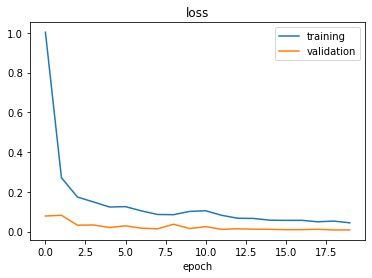

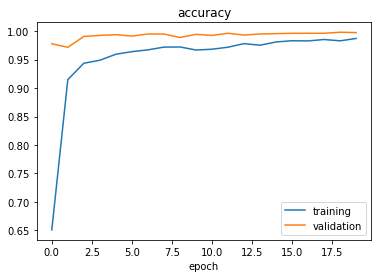

In [57]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('accuracy')
plt.xlabel('epoch')
plt.show()

In [58]:
score = model.evaluate(X_test, y_test, verbose=0) 
print('Test score = ', score[0]) 
print('Test accuracy = ', score[1])

Test score =  0.021844198927283287
Test accuracy =  0.9955708384513855


In [ ]:
width = 640
height = 480

In [ ]:
cap = cv2.VideoCapture(0)
cap.set(3, width)
cap.set(4, height)

In [ ]:
 while True:
    success, imgOriginal = cap.read()
    img = np.asarray(imgOriginal)
    img = cv2.resize(img,(32,32))
    img = preProcessing(img)
    cv2.imshow("Processed image", img)
    img = img.reshape(1,32,32,1)
    
    classIndex = int(np.argmax(model.predict(img), axis=-1))
    #print(classIndex)
    
    predictions = model.predict(img)
    #print(predictions)
    probVal = np.amax(predictions)
    #print(classIndex, probVal)
    
    if probVal > threshold:
        cv2.putText(imgOriginal, str(classIndex) +" "+ str(probVal), (50,50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255), 1)
    cv2.imshow("original Image", imgOriginal)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

In [ ]:
# After the loop release the cap object
vid.release()
# Close all windows
cv2.destroyAllWindows()